## 1) Import packages

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder,normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras


## 2) Loda data

In [15]:
from google.colab import drive
drive.mount("/content/drive/")
data_folder='drive/My Drive/data_for_workshop/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
# Read mRNA data
mrna_address = data_folder + 'mrna.csv'
mrna = pd.read_csv(mrna_address, index_col=0)
new_mrna = mrna.to_numpy().transpose()

# Read disease data and encode labels
disease_address = data_folder + 'disease.csv'
disease = pd.read_csv(disease_address, index_col=0).to_numpy()
new_disease = np.ravel(disease)
LabelEncoder_disease = LabelEncoder()
LabelEncoder_disease.fit(new_disease)
encoded_disease = LabelEncoder_disease.transform(new_disease)

# Read tissue data and encode labels
tissue_address = data_folder + 'tissue.csv'
tissue = pd.read_csv(tissue_address, index_col=0).to_numpy()
new_tissue = np.ravel(tissue)
LabelEncoder_tissue = LabelEncoder()
LabelEncoder_tissue.fit(new_tissue)
encoded_tissue = LabelEncoder_tissue.transform(new_tissue)


## 3) EDA

In [17]:
print('mRNA data shape:', mrna.shape)

# Describe dataframe
mrna.describe()

mRNA data shape: (18154, 2605)


,0,1,2,3,4,5,6,7,8,9,...,7332,7333,7334,7335,7336,7337,7338,7339,7340,7341
count,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,...,18154.000000,18154.00000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000
mean,1.685789e+03,1545.168840,1229.837460,1505.044150,1345.194259,1459.959980,1418.866510,1355.848642,1.869914e+03,1383.524081,...,1336.420517,1118.69304,1655.220936,1533.370326,1405.414681,1418.029114,1296.141233,1501.950030,1346.404463,1156.920609
std,1.929549e+04,12499.623821,9636.220897,12118.720827,10451.080552,11640.223926,11948.483223,9743.450064,2.589430e+04,9703.221123,...,10882.473853,10415.13896,13386.382963,12561.184288,13668.507786,17954.660897,11440.348896,14731.928048,11683.296368,12491.574595
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.359000e+01,13.620000,15.560000,28.240000,13.420000,26.145000,30.560000,27.050000,1.352000e+01,30.120000,...,30.340000,14.35000,22.100000,28.240000,29.752500,34.510000,25.170000,31.900000,33.300000,17.130000
50%,1.970900e+02,158.790000,170.250000,211.310000,150.170000,212.780000,226.540000,224.970000,1.599000e+02,218.790000,...,215.770000,150.17000,156.590000,199.850000,208.380000,232.130000,186.400000,233.755000,220.320000,164.420000
75%,6.515800e+02,612.110000,616.370000,688.780000,587.130000,665.290000,713.110000,713.110000,6.036700e+02,703.280000,...,669.920000,575.03000,559.280000,656.110000,660.680000,684.020000,638.150000,698.410000,679.290000,591.220000
max,1.255646e+06,472513.800000,589853.660000,546551.290000,414208.180000,517068.970000,778316.890000,431797.890000,1.715264e+06,499455.670000,...,573724.060000,573724.06000,581732.960000,535303.410000,677564.080000,992012.340000,527933.710000,783730.520000,569761.050000,834179.460000


In [18]:
mrna.head()

,0,1,2,3,4,5,6,7,8,9,...,7332,7333,7334,7335,7336,7337,7338,7339,7340,7341
RIMS4,642.59,457.25,633.73,848.22,713.11,638.15,684.02,567.10,713.11,595.34,...,460.44,476.71,339.14,406.31,490.14,480.04,417.77,447.82,466.88,490.14
OR2A7,0.41,2.41,0.00,1.22,0.00,7.06,0.00,0.00,0.00,0.00,...,0.27,0.23,0.56,0.55,0.85,0.28,0.56,0.29,0.27,0.00
INSM1,764.36,476.71,616.37,1044.52,571.05,780.44,1437.15,1277.29,575.03,1477.58,...,624.99,303.44,447.82,470.14,490.14,733.19,285.03,480.04,454.09,339.14
CHRNB1,1857.60,4038.61,2573.36,1685.71,2351.53,1819.35,1529.73,1417.35,3103.19,1651.00,...,2777.33,2384.37,4298.64,3716.20,2367.90,2148.82,2209.26,2400.97,2240.11,2351.53
FUT7,3690.52,2956.17,1605.83,2777.33,1769.57,2935.74,3742.05,4512.40,1096.50,2384.37,...,2664.15,2090.03,2319.15,2451.44,2400.97,1883.54,2485.67,1870.53,2287.20,1561.89


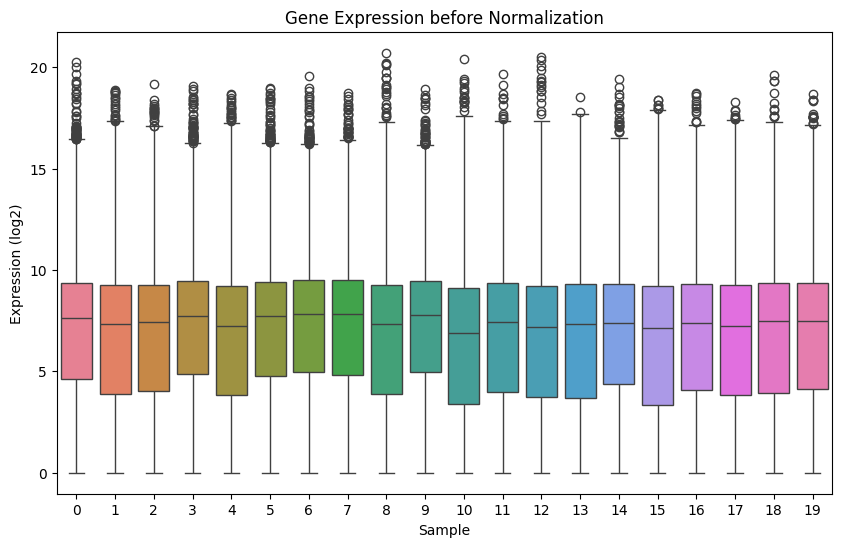

In [ ]:
# Data distribution
plt.figure(figsize=(10,6))
sns.boxplot(np.log2(mrna.iloc[:,:20]+1), palette='husl')
plt.xlabel('Sample')
plt.ylabel('Expression (log2)')
plt.title('Gene Expression before Normalization')
plt.show()

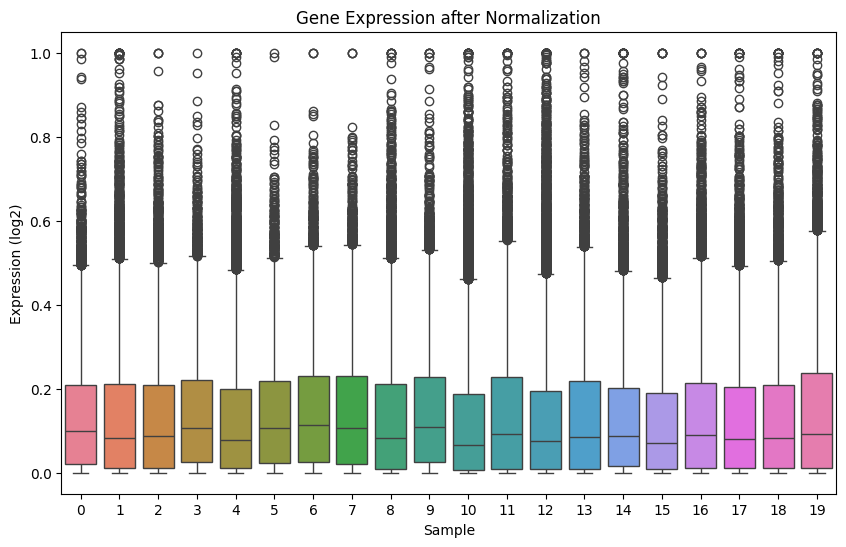

In [ ]:
# Gene expression normalization across samples
new_mrna01 = normalize(mrna, axis=1, norm="max")
plt.figure(figsize=(10,6))
sns.boxplot(np.log2(new_mrna01[:,:20]+1), palette='husl')
plt.xlabel('Sample')
plt.ylabel('Expression (log2)')
plt.title('Gene Expression after Normalization')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


Text(0, 0.5, 'Density')

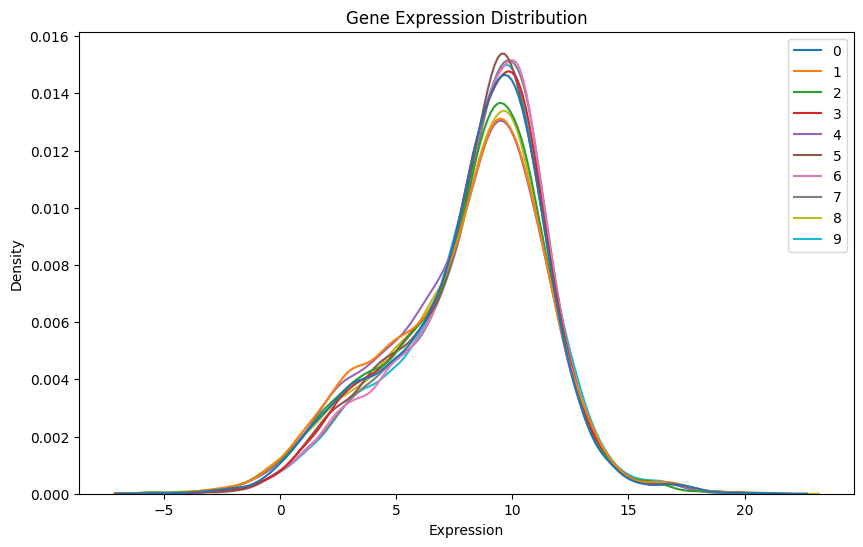

In [ ]:
# Distribution plot of genes across different samples
plt.figure(figsize=(10,6))
sns.kdeplot(data=np.log2(mrna.iloc[:,:10])+1)
plt.title('Gene Expression Distribution')
plt.xlabel('Expression')
plt.ylabel('Density')

,Disease,Count
0,Normal,630
1,Tumor,1975


,Tissue,Count
0,bladder,390
1,breast,1181
2,cervix,272
3,colon,762


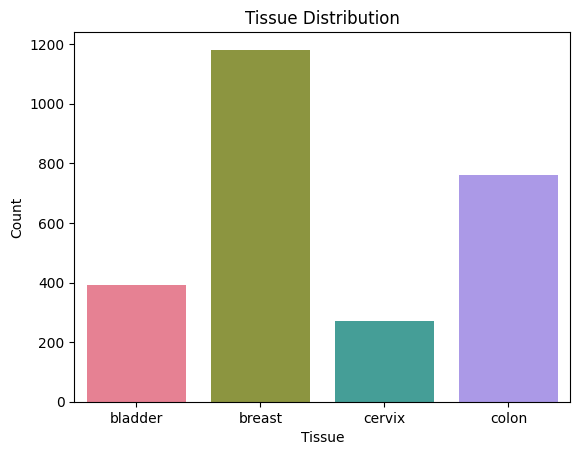

In [ ]:
ds_type, ds_count = np.unique(disease, return_counts=True)
ds_df = pd.DataFrame({'Disease': ds_type, 'Count':ds_count})
display(ds_df)
tissue_type, tissue_count = np.unique(tissue, return_counts=True)
tissue_df = pd.DataFrame({'Tissue': tissue_type, 'Count': tissue_count})
display(tissue_df)

# Describe dataframe
tissue_df.describe()
#color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467']
#plt.bar(tissue_type, tissue_count, color= color_palette)
sns.barplot(x='Tissue', y='Count', data=tissue_df, palette='husl', hue='Tissue')
plt.xlabel('Tissue')
plt.ylabel('Count')
plt.title('Tissue Distribution')
plt.show()

## 4) Prepare data for training

In [19]:
###### shuffle data
indices=np.arange(new_mrna.shape[0])
# shuffle samples' indices
np.random.shuffle(indices)
# Extract data with shuffled samples
shuffled_mrna=new_mrna[indices,:]
shuffled_disease=encoded_disease[indices]
shuffled_tissue=encoded_tissue[indices]

#split data into train, val and, test sets
# normalize gene expression data across samples
normalized_mrna=normalize(shuffled_mrna,axis=0,norm="max")
# Take 70% of data for training
train_mrna=normalized_mrna[0:int(.7*normalized_mrna.shape[0]),:]
# Take 10% of data for validation
val_mrna=normalized_mrna[int(0.7*normalized_mrna.shape[0]):int(.8*normalized_mrna.shape[0]),:]
# Take 20% of data for testing
test_mrna=normalized_mrna[int(.8*normalized_mrna.shape[0]):,:]

train_disease=shuffled_disease[0:int(.7*normalized_mrna.shape[0])]
val_disease=shuffled_disease[int(.7*normalized_mrna.shape[0]):int(.8*normalized_mrna.shape[0])]
test_disease=shuffled_disease[int(.8*normalized_mrna.shape[0]):]

train_tissue=shuffled_tissue[0:int(.7*normalized_mrna.shape[0])]
val_tissue=shuffled_tissue[int(.7*normalized_mrna.shape[0]):int(.8*normalized_mrna.shape[0])]
test_tissue=shuffled_tissue[int(.8*normalized_mrna.shape[0]):]

## 5) Build Model

In [31]:
# Build model

input_layer = Input(shape=(normalized_mrna.shape[1],), name="input")
dense_1 = Dense(units=1024, activation='relu', name='dense1')(input_layer)
drop_1 = Dropout(rate=0.2)(dense_1)
dense_2 = Dense(units=64, activation='relu', name='dense2')(drop_1)
disease_output = Dense(units=1, activation='sigmoid', name='disease_out')(dense_2)
tissue_output = Dense(units=4, activation='softmax', name='tissue_out')(dense_2)

# Define optimizer with a specific learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

classifier = Model(inputs=input_layer, outputs=[disease_output, tissue_output])
classifier.compile(optimizer=optimizer,
                   loss=[keras.losses.binary_crossentropy, keras.losses.categorical_crossentropy],
                   loss_weights=[0.5, 0.5],
                   metrics={'disease_out': 'accuracy', 'tissue_out': 'accuracy'})

# Summary of the model
classifier.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 18154)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 1024)           │     18,590,720 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 1024)           │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 64)             │         65,600 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ disease_out (Dense)       │ (None, 1)              │             65 │ dense2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tissue_out (Dense)        │ (None, 4)              │            260 │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,656,645 (71.17 MB)

 Trainable params: 18,656,645 (71.17 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# We can either split data into train, validation and test set manually or using the sklearn function
from sklearn.model_selection import train_test_split

# Split the original dataset into training+validation and test sets
train_mrna, test_mrna, train_disease, test_disease, train_tissue, test_tissue = train_test_split(normalized_mrna, shuffled_disease, shuffled_tissue,
            test_size=0.1, random_state=42)

In [35]:
# Function to reset the model's weights in each round of cross-validation
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.keras.backend.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.keras.backend.shape(layer.bias)))


# K-fold cross-validation on train+val set
num_samples = train_mrna.shape[0]
list_num = list(range(num_samples))
num_fold = 3

histories = []

for i in range(num_fold):
    val_fold_mrna = train_mrna[int((i) * (num_samples / num_fold)):int((i + 1) * (num_samples / num_fold)), :]
    train_fold_mrna = np.delete(train_mrna, list_num[int((i) * (num_samples / num_fold)):int((i + 1) * (num_samples / num_fold))], axis=0)

    val_fold_disease = train_disease[int((i) * (num_samples / num_fold)):int((i + 1) * (num_samples / num_fold))]
    train_fold_disease = np.delete(train_disease, list_num[int((i) * (num_samples / num_fold)):int((i + 1) * (num_samples / num_fold))])

    val_fold_tissue = train_tissue[int((i) * (num_samples / num_fold)):int((i + 1) * (num_samples / num_fold))]
    train_fold_tissue = np.delete(train_tissue, list_num[int((i) * (num_samples / num_fold)):int((i + 1) * (num_samples / num_fold))], axis=0)

    # One-hot encode tissue labels
    train_fold_tissue = to_categorical(train_fold_tissue, num_classes=4)
    val_fold_tissue = to_categorical(val_fold_tissue, num_classes=4)

    print('fold:', i+1)
    # with open(data_folder + "real_disease.csv", "ab") as file:
    #     np.savetxt(file, val_fold_disease)

    # Reset the model's weights
    reset_weights(classifier)

    # Train the model and store the history
    history = classifier.fit(train_fold_mrna, [train_fold_disease, train_fold_tissue], epochs=30, batch_size=64, validation_data=(val_fold_mrna, [val_fold_disease, val_fold_tissue]), verbose=1)
    histories.append(history.history)

    classifier.evaluate(val_fold_mrna, [val_fold_disease, val_fold_tissue])
    predicted_disease = classifier.predict(val_fold_mrna)[0]

    # with open(data_folder + "predicted_disease.csv", "ab") as file:
    #     np.savetxt(file, predicted_disease)


fold: 1
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 586ms/step - disease_out_accuracy: 0.8275 - disease_out_loss: 0.2129 - loss: 0.6676 - tissue_out_accuracy: 0.6266 - tissue_out_loss: 0.4541 - val_disease_out_accuracy: 0.9821 - val_disease_out_loss: 0.0340 - val_loss: 0.1241 - val_tissue_out_accuracy: 0.9513 - val_tissue_out_loss: 0.0917
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 584ms/step - disease_out_accuracy: 0.9880 - disease_out_loss: 0.0324 - loss: 0.1017 - tissue_out_accuracy: 0.9677 - tissue_out_loss: 0.0692 - val_disease_out_accuracy: 0.9872 - val_disease_out_loss: 0.0170 - val_loss: 0.0642 - val_tissue_out_accuracy: 0.9680 - val_tissue_out_loss: 0.0474
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 538ms/step - disease_out_accuracy: 0.9895 - disease_out_loss: 0.0187 - loss: 0.0519 - tissue_out_accuracy: 0.9850 - tissue_out_loss: 0.0333 - val_disease_out_accuracy: 0.9923 - val_disease_out_loss: 0.0136 - val_loss: 0.0476 - val_tissue_out_accuracy: 0.9821 - val_tissue_out_loss: 0.0337

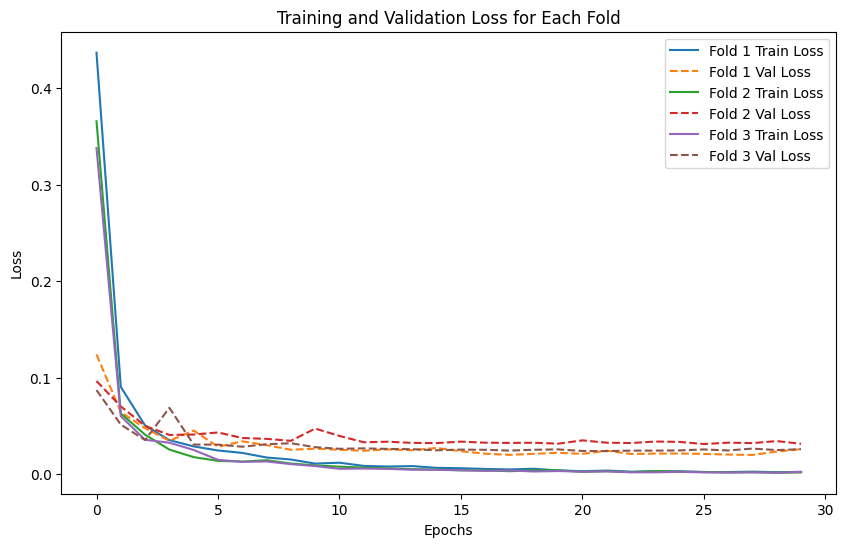

In [36]:
# Plot the training and validation loss for each fold
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], '--', label=f'Fold {i+1} Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Each Fold')
plt.legend()
plt.show()



In [54]:
# Final evaluation on the test set
test_tissue = to_categorical(test_tissue, num_classes=4)
test_eval = classifier.evaluate(test_mrna, [test_disease, test_tissue])
print("Test evaluation:", test_eval)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - disease_out_accuracy: 1.0000 - disease_out_loss: 0.0015 - loss: 0.0115 - tissue_out_accuracy: 0.9846 - tissue_out_loss: 0.0100
Test evaluation: [0.011661926284432411, 0.002095261123031378, 0.009344409219920635, 1.0, 0.9885057210922241]


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 18154)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 1024)           │     18,590,720 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 1024)           │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 64)             │         65,600 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ disease_out (Dense)       │ (None, 1)              │             65 │ dense2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tissue_out (Dense)        │ (None, 4)              │            260 │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,656,645 (71.17 MB)

 Trainable params: 18,656,645 (71.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - disease_out_accuracy: 0.8399 - disease_out_loss: 0.1838 - loss: 0.5906 - tissue_out_accuracy: 0.6992 - tissue_out_loss: 0.4062 - val_disease_out_accuracy: 0.9839 - val_disease_out_loss: 0.0320 - val_loss: 0.1160 - val_tissue_out_accuracy: 0.9482 - val_tissue_out_loss: 0.0845
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - disease_out_accuracy: 0.9831 - disease_out_loss: 0.0332 - loss: 0.1066 - tissue_out_accuracy: 0.9661 - tissue_out_loss: 0.0734 - val_disease_out_accuracy: 0.9862 - val_disease_out_loss: 0.0200 - val_loss: 0.0682 - val_tissue_out_accuracy: 0.9758 - val_tissue_out_loss: 0.0492
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - disease_out_accuracy: 0.9873 - disease_out_loss: 0.0187 - loss: 0.0567 - tissue_out_accuracy: 0.9844 - tissue_out_loss: 0.0378 - val_disease_out_accuracy: 0.9873 - val_disease_out_loss: 0.0160 - val_loss: 0.0477 - val_tissue_out_accuracy: 0.9804 - val_tissue_out_loss: 0.0317
Epoch 4/30
2

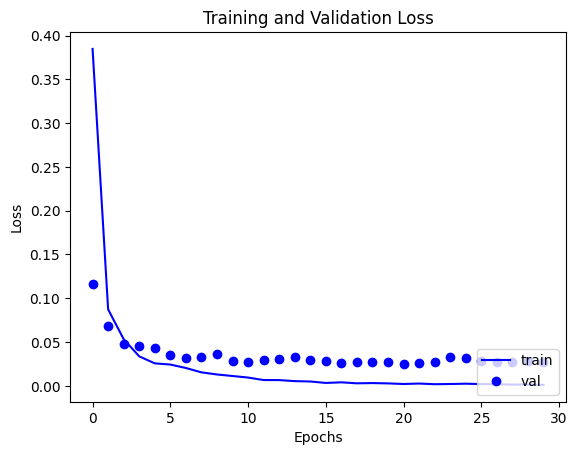

In [ ]:
#### Plot and summary of model
tf.keras.utils.plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
classifier.summary()

# Train the model
learn_history = classifier.fit(train_mrna, [train_disease, train_tissue], epochs=30, batch_size=64, validation_data=(val_mrna, [val_disease, val_tissue]))

### Plot loss
import matplotlib.pyplot as plt
plt.plot(learn_history.history['loss'], 'b')
plt.plot(learn_history.history['val_loss'], 'bo')
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 18154)]           0         
                                                                 
 dense1 (Dense)              (None, 1024)              18590720  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense2 (Dense)              (None, 64)                65600     
                                                                 
 tissue_out (Dense)          (None, 4)                 260       
                                                                 
Total params: 18,656,580
Trainable params: 18,656,580
Non-trainable params: 0
_________________________________________________________________


In [69]:
predicted_ds=pd.read_csv(data_folder+"predicted_disease.csv",header=None)
true_ds=pd.read_csv(data_folder+"true_disease.csv",header=None)
y=(predicted_ds>0.5)

from sklearn.metrics import confusion_matrix
confusion_matrix(true_ds,y)

In [ ]:
len(classifier.predict(test_mrna))

2

In [ ]:
classifier.predict(test_mrna)[0].shape

(261, 1)

In [ ]:
# Tissue prediction results
classifier.predict(test_mrna)[1]

array([[0.01218216, 0.96535325, 0.01686028, 0.00560433],
       [0.01149194, 0.96824473, 0.01495943, 0.00530391],
       [0.01302533, 0.9633335 , 0.0173154 , 0.0063258 ],
       ...,
       [0.01068576, 0.9724087 , 0.01226942, 0.00463619],
       [0.93994397, 0.02199997, 0.02081494, 0.01724102],
       [0.036371  , 0.10027703, 0.76937324, 0.09397872]], dtype=float32)

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
learn_history.history.keys()

dict_keys(['loss', 'disease_out_loss', 'tissue_out_loss', 'disease_out_accuracy', 'tissue_out_accuracy', 'val_loss', 'val_disease_out_loss', 'val_tissue_out_loss', 'val_disease_out_accuracy', 'val_tissue_out_accuracy'])

In [ ]:
learn_history.history['loss']

[0.25594809651374817,
 0.1480461210012436,
 0.10920409113168716,
 0.08504463732242584,
 0.06927564740180969,
 0.05485120788216591,
 0.03967656195163727,
 0.033526547253131866,
 0.026813996955752373,
 0.019457338377833366,
 0.014856550842523575,
 0.020085928961634636,
 0.013919951394200325,
 0.008407091721892357,
 0.007283409126102924,
 0.008292948827147484,
 0.004843217320740223,
 0.006830692756921053,
 0.006108267232775688,
 0.004472643602639437,
 0.0037110026460140944,
 0.002277862746268511,
 0.002624297048896551,
 0.00561909843236208,
 0.002330076415091753,
 0.0020170481875538826,
 0.0028979249764233828,
 0.006714118644595146,
 0.0031200177036225796,
 0.0015283910324797034]

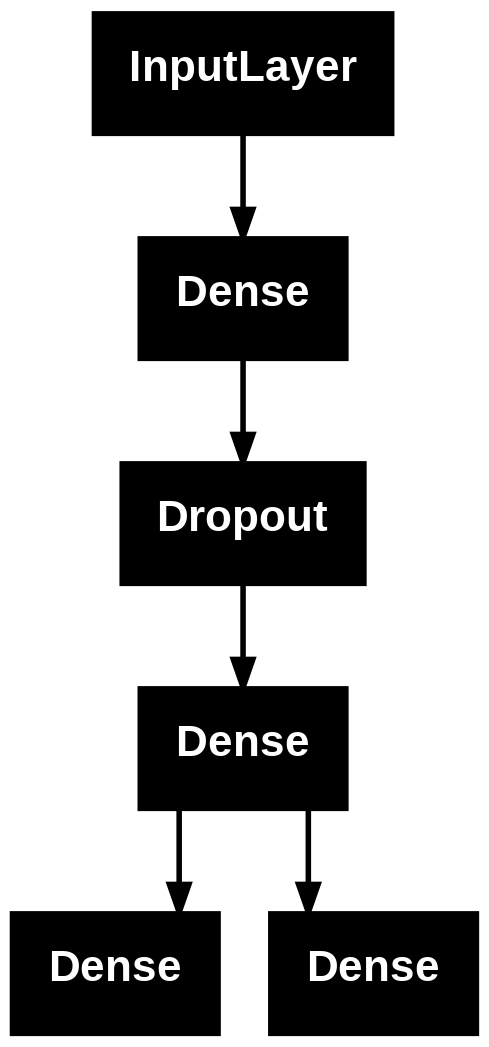

In [55]:
import tensorflow as tf
tf.keras.utils.plot_model(classifier)

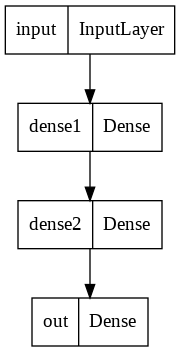

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(classifier)